<a href="https://colab.research.google.com/github/sakshamgarg/Augmenting-Dirichlet-Network/blob/main/out_of_distribution_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import torch
import os
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
args_checkpoint = 'cifar10_resnet_variational_dirichlet'
args_ind_dataset = 'cifar10'
args_ood_dataset = 'svhn'
args_model = 'resnet18'
args_batch_size = 128

cudnn.benchmark = True  # Should make training should go faster for large models

filename = args_checkpoint

proj_filename = '/content/drive/My Drive/CV/checkpoint/{}_{}_proj.pt'.format(args_ind_dataset, args_model)


import matplotlib
matplotlib.set_loglevel("error")


In [3]:
###########################
### Set up data loaders ###
###########################

# For ind_dataset = cifar10
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

transform = transforms.Compose([transforms.ToTensor(),
                                normalize])
num_classes = 10
ind_dataset = datasets.CIFAR10(root='data/',
                                train=False,
                                transform=transform,
                                download=True)
ood_dataset = datasets.SVHN(root='data/', split='test', transform=transform, download=True)

ind_loader = torch.utils.data.DataLoader(dataset=ind_dataset,
                                         batch_size=args_batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)

ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset,
                                         batch_size=args_batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


  0%|          | 0/64275384 [00:00<?, ?it/s]

In [4]:
from torch.nn.parameter import Parameter


class Transit(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(Transit, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.copy_(0.01 * torch.ones(self.in_features, self.out_features))
        if self.bias is not None:
            self.bias.data.copy_(torch.zeros(self.out_features, ))

    def forward(self, input):
        weight = torch.relu(self.weight)
        #bias = torch.clamp(self.bias, min=0)
        #norm_input = torch.norm(input, 2, -1)
        epsilon = F.linear(input, weight, self.bias)
        #norm_epsilon = torch.norm(epsilon, 2, -1)
        #ratio = norm_epsilon / norm_input
        #scale = torch.max(ratio / 0.1, torch.ones(ratio.shape[0], ).cuda()).unsqueeze(-1)
        #epsilon = epsilon / scale
        return epsilon + input

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [5]:
##############################
### Load pre-trained model ###
##############################

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out, None


def ResNet18(num_classes):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)


In [6]:
cnn = ResNet18(num_classes=num_classes)

cnn = torch.nn.DataParallel(cnn)
cnn.to(device)

proj = Transit(num_classes, num_classes, bias=False)
proj.to(device)

pretrained_dict = torch.load('/content/drive/My Drive/CV/checkpoint/' + filename + '.pt')
if "state_dict" in pretrained_dict:
    pretrained_dict = pretrained_dict['state_dict']
cnn.load_state_dict(pretrained_dict)

if os.path.exists(proj_filename):
    pretrained_dict = torch.load(proj_filename)
    proj.load_state_dict(pretrained_dict)

cnn.eval()


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [7]:
## utils.py

clamp_threshold = 1000

def entropy(alpha):
    alpha0 = torch.sum(alpha, 1)
    logB = torch.sum(torch.lgamma(alpha), 1) - torch.lgamma(alpha0)
    digamma_1 = (alpha0 - alpha.size(1)) * torch.digamma(alpha0)
    digamma_2 = -torch.sum((alpha - 1) * torch.digamma(alpha), 1)
    entropy = logB + digamma_1 + digamma_2
    return entropy, logB, digamma_1, digamma_2

def obtain_dirichelets(logits, func=lambda x:torch.relu(x), mean=False):
    alpha = torch.exp(logits).clamp(0, clamp_threshold)
    evidence = func(alpha) 
    ent, ret1, ret2, ret3 = entropy(evidence)    
    conf = -ent
    if mean:
        conf = torch.mean(conf)
    return alpha, evidence, conf

def one_hot(seq_batch, depth):
    # seq_batch.size() should be [seq,batch] or [batch,]
    # return size() would be [seq,batch,depth] or [batch,depth]
    out = torch.zeros(seq_batch.size()+torch.Size([depth])).cuda()
    dim = len(seq_batch.size())
    index = seq_batch.view(seq_batch.size()+torch.Size([1]))
    return out.scatter_(dim,index,1)

def mse_loss(label, alpha, max_weight, option="variational"):
    loss = -(torch.digamma(alpha) - torch.digamma(alpha.sum(-1)).unsqueeze(-1))
    selected_loss = loss.gather(1, label.unsqueeze(-1)).squeeze()
   
    mask = 1 - one_hot(label, alpha.size(1))
    appended = one_hot(label, alpha.size(1))
    alpha = alpha * mask + appended

    def KL(alp):
        beta = torch.FloatTensor(1, alpha.size(1)).fill_(1.0).cuda()
        S_alpha = torch.sum(alpha, -1, True)
        S_beta = torch.sum(beta, -1, True)
        lnB = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alpha), -1, True)
        lnB_uni = torch.sum(torch.lgamma(beta), -1, True) - torch.lgamma(S_beta)
        dg0 = torch.digamma(S_alpha)
        dg1 = torch.digamma(alpha)
        kl = torch.sum((alpha - beta) * (dg1 - dg0), -1, True) + lnB + lnB_uni
        return kl

    return selected_loss, max_weight * KL(alpha)

def reproject_dirichlets(logits, proj, model, mean=False, logscale=False):
    if logscale:
        alphas = torch.log(torch.exp(logits) + 1) + 1
    else:
        alphas = torch.exp(logits).clamp(0, clamp_threshold)
    alphas = proj(alphas)

    scale = torch.max(alphas,dim=-1,keepdim=True)[0] / clamp_threshold
    scale = torch.clamp(scale, min=1)
    alphas = alphas / scale

    ent, ret1, ret2, ret3 = entropy(alphas)
    conf = -ent
    if mean:
        conf = torch.mean(conf)
    return conf, alphas


In [8]:
##############################################
### Evaluate out-of-distribution detection ###
##############################################
def evaluate(data_loader, mode):
    out = []
    all_alphas = []
    all_ratios = []
    xent = nn.CrossEntropyLoss()
    for data in data_loader:
        if type(data) == list:
            images, labels = data
        else:
            images = data

        images = Variable(images, requires_grad=True).cuda()
        images.retain_grad()

        if mode == 'dirichlet':
            cnn.zero_grad()
            pre_logits, _ = cnn(images)
            f = lambda x: torch.log(x+1)
            
            alphas, _, confidence = obtain_dirichelets(pre_logits, func=f, mean=False)
            _, pred_idx = torch.max(pre_logits.data, 1)
            loss = torch.mean(mse_loss(Variable(pred_idx), alphas, 0, option="variational")[0])
            loss.backward()
            images = images - args_epsilon * torch.sign(images.grad)
            
            pre_logits, _ = cnn(images)
            alphas, evidence, confidence = obtain_dirichelets(pre_logits, func=f, mean=False)
            
            all_alphas.append(evidence.view(-1).data.cpu().numpy())
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'cross_entropy':
            cnn.zero_grad()
            pre_logits, _ = cnn(images)
            f = lambda x : torch.relu(x)

            _, pred_idx = torch.max(pre_logits.data, 1)
            #loss = xent(pre_logits, pred_idx)
            alphas, evidence, confidence = obtain_dirichelets(pre_logits, func=f, mean=True)
            loss = -confidence
            loss.backward()
            images = images - args_epsilon * torch.sign(images.grad)
            
            pre_logits, _ = cnn(images)
            alphas, evidence, confidence = obtain_dirichelets(pre_logits, func=f, mean=False)
            
            all_alphas.append(evidence.view(-1).data.cpu().numpy())
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'finetune':
            pre_logits, _ = cnn(images)
            confidence, alphas = reproject_dirichlets(pre_logits, proj, args_model, mean=False, logscale=args_logscale)
            #confidence, alphas = reproject_dirichlets(pre_logits, lambda x:x, args_model, mean=False, logscale=args_logscale)

            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'perturbation_magnitude':
            pre_logits, _ = cnn(images)
            confidence, alphas = reproject_dirichlets(pre_logits, proj, args_model, mean=False)
            orig_confidence, orig_alphas = reproject_dirichlets(pre_logits, lambda x:x, args_model, mean=False)

            perturb = alphas - orig_alphas
            perturb_norm = torch.max(perturb, -1)[0]#torch.norm(perturb, 2, -1)
            old_norm = torch.max(orig_alphas, -1)[0]#torch.norm(orig_alphas, 2, -1)
            ratio = (perturb_norm / old_norm)
            ratio = ratio.cpu().cpu().data.numpy()
            ratio = ratio[ratio < 0.12]
            all_ratios.append(ratio)

        elif mode == 'plot_alpha':
            pre_logits, _ = cnn(images)
            confidence, alphas = reproject_dirichlets(pre_logits, proj, args_model, mean=False)
            orig_confidence, orig_alphas = reproject_dirichlets(pre_logits, lambda x:x, args_model, mean=False)

            alphas = alphas.cpu().data.numpy()
            orig_alphas = orig_alphas.cpu().data.numpy()
           
            fig, axes = plt.subplots(nrows=1, ncols=2)
            extent = [1, 100, 1, args_batch_size]
            for i, ax in enumerate(axes.flat):
                if i == 0:
                    im = ax.imshow(orig_alphas, extent=extent, interpolation='none')
                    ax.title.set_text("before")
                else:
                    im = ax.imshow(alphas, extent=extent, interpolation='none')
                    ax.title.set_text("after")
                ax.set_xlabel("CIFA100 classes")
                if i == 0:
                    ax.set_ylabel("Samples")

            fig.subplots_adjust(right=0.8)
            cax = fig.add_axes([0.85,0.2,0.03,0.6])
            fig.colorbar(im, cax=cax)
            plt.savefig("images/alpha_projection.eps", format='eps', dpi=200)

            sys.exit(0)

        elif mode == 'plot_confidence':
            pre_logits, _ = cnn(images)
            orig_confidence, orig_alphas = reproject_dirichlets(pre_logits, lambda x:x, args_model, mean=False)

            f = lambda x : torch.relu(x)
            alphas, evidence, confidence = obtain_dirichelets(pre_logits, func=f, mean=True)
            loss = -confidence
            loss.backward()
            images = images - args_epsilon * torch.sign(images.grad)
            pre_logits, _ = cnn(images)
            confidence, alphas = reproject_dirichlets(pre_logits, lambda x:x, args_model, mean=False)

            confidence = confidence.cpu().data.numpy()
            orig_confidence = orig_confidence.cpu().data.numpy()

            plt.hist(orig_confidence, bins=50, label='before perturbation')
            plt.hist(confidence, bins=50, label='after perturbation')
            plt.title("Confidence Shift after Perturbation")
            plt.legend()
            plt.xlabel('Confidence')
            plt.ylabel('Density')

            #fig, axes = plt.subplots(nrows=1, ncols=2)
            #extent = [0.05, 1.0, 1.0, 0.05]
            #for i, ax in enumerate(axes.flat):
            #    if i == 0:
            #        im = ax.hist(orig_confidence, bins=50, density=True)
            #        ax.title.set_text("before")
            #    else:
            #        im = ax.hist(confidence, bins=50, density=True)
            #        ax.title.set_text("after")
            #    ax.set_xlabel("Confidence")
            #plt.tight_layout()

            plt.savefig("images/ood_confidence_projection.eps", format='eps', dpi=200)
            sys.exit(0)

        elif mode == 'variational':
            cnn.train()
            images = images.repeat(100, 1, 1, 1)
            pre_logits , _ = cnn(images)
            probs = nn.functional.softmax(pre_logits, -1).view(100, args_batch_size, -1)

            avg_probs = probs.mean(0)
            entropy_avg = -torch.sum(avg_probs * torch.log(avg_probs), -1)

            avg_entropy = -torch.sum(probs * torch.log(probs), -1).mean(0)

            conf = -(entropy_avg - avg_entropy).data.cpu().numpy()
            out.append(conf)
            if len(out) > 100:
                break
            else:
                print("finished {}".format(len(out)))

        elif mode == 'confidence':
            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'confidence_scaling':
            epsilon = args_epsilon

            cnn.zero_grad()
            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence).view(-1)
            loss = torch.mean(-torch.log(confidence))
            loss.backward()

            images = images - args_epsilon * torch.sign(images.grad)
            images = Variable(images.data, requires_grad=True)

            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'baseline':
            # https://arxiv.org/abs/1610.02136
            pred, _ = cnn(images)
            pred = F.softmax(pred, dim=-1)
            pred = torch.max(pred.data, 1)[0]
            #pred = torch.sum(pred * torch.log(pred), -1).data
            pred = pred.cpu().numpy()
            out.append(pred)

        elif mode == 'ODIN':
            # https://arxiv.org/abs/1706.02690
            T = args_T
            epsilon = args_epsilon

            cnn.zero_grad()
            pred, _ = cnn(images)
            _, pred_idx = torch.max(pred.data, 1)
            labels = Variable(pred_idx)
            pred = pred / T
            loss = xent(pred, labels)
            loss.backward()
            
            images = images - epsilon * torch.sign(images.grad)
            images = Variable(images.data, requires_grad=True)

            pred, _ = cnn(images)

            pred = pred / T
            pred = F.softmax(pred, dim=-1)
            pred = torch.max(pred.data, 1)[0]
            pred = pred.cpu().numpy()
            out.append(pred)

    out = np.concatenate(out)

    # all_ratios = np.concatenate(all_ratios)
    plt.figure()
    # sns.distplot(all_ratios, kde=False, bins=100, norm_hist=False)
    sns.distplot(out, kde=False, bins=100, norm_hist=False)
    plt.xlabel("Perturbation Ratio")
    plt.ylabel("Density") 
    plt.savefig("./perturbation_ratio_distribution.eps", format='eps', dpi=1000)
    ## commented out by saksham
    # sys.exit(0)
    return out


In [9]:
## ood_metrics.py

def tpr95(ind_confidences, ood_confidences):
    #calculate the falsepositive error when tpr is 95%
    Y1 = ood_confidences
    X1 = ind_confidences
    delta = np.percentile(X1, 5)
    fprBase = np.sum(np.sum(Y1 > delta)) / float(len(Y1))
    """
    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / 100000

    total = 0.0
    fpr = 0.0

    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            fpr += error2
            total += 1
    fprBase = fpr / total
    """
    return fprBase


def detection(ind_confidences, ood_confidences, n_iter=100000, return_data=False):
    # calculate the minimum detection error
    Y1 = ood_confidences
    X1 = ind_confidences

    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / n_iter

    best_error = 1.0
    best_delta = None
    all_thresholds = []
    all_errors = []
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / float(len(Y1))
        detection_error = (tpr + error2) / 2.0

        if return_data:
            all_thresholds.append(delta)
            all_errors.append(detection_error)

        if detection_error < best_error:
            best_error = np.minimum(best_error, detection_error)
            best_delta = delta

    if return_data:
        return best_error, best_delta, all_errors, all_thresholds
    else:
        return best_error, best_delta


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



Method: dirichlet
TPR95 (lower is better):  0.9970036877688998
Detection error (lower is better):  0.4049195759065765
Best threshold: 17.948097401423166
AUROC (higher is better):  0.5257074408420406
AUPR_IN (higher is better):  0.45081924642522964
AUPR_OUT (higher is better):  0.6839100990504525
Plotting in the end


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


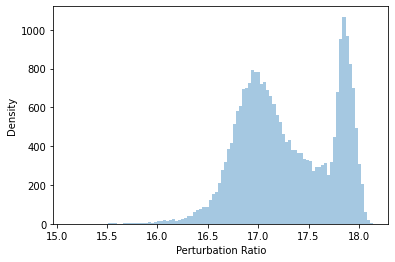

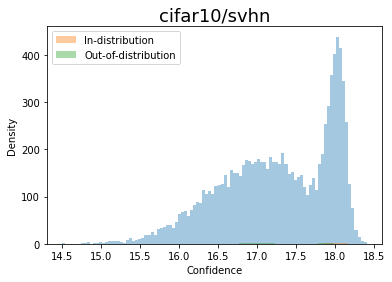

In [10]:
args_process = 'dirichlet'
args_logscale = False
args_epsilon = 0.2
args_T = 1000.


ood_scores = evaluate(ood_loader, args_process)
ood_labels = np.zeros(ood_scores.shape[0])
ind_scores = evaluate(ind_loader, args_process)
ind_labels = np.ones(ind_scores.shape[0])

labels = np.concatenate([ind_labels, ood_labels])
scores = np.concatenate([ind_scores, ood_scores])

fpr_at_95_tpr = tpr95(ind_scores, ood_scores)
detection_error, best_delta = detection(ind_scores, ood_scores)
auroc = metrics.roc_auc_score(labels, scores)
aupr_in = metrics.average_precision_score(labels, scores)
aupr_out = metrics.average_precision_score(-1 * labels + 1, 1 - scores)

print("")
print("Method: " + args_process)
print("TPR95 (lower is better): ", fpr_at_95_tpr)
print("Detection error (lower is better): ", detection_error)
print("Best threshold:", best_delta)
print("AUROC (higher is better): ", auroc)
print("AUPR_IN (higher is better): ", aupr_in)
print("AUPR_OUT (higher is better): ", aupr_out)

args_plot = True

if args_plot:
    ranges = (np.min(scores), np.max(scores))
    sns.distplot(ind_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=100, norm_hist=True, label='In-distribution')
    sns.distplot(ood_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=100, norm_hist=True, label='Out-of-distribution')
    plt.title("{}/{}".format(args_ind_dataset, args_ood_dataset), fontsize=18)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    #plt.title(args_ood_dataset)
    # plt.xlim(0, 150)
    # plt.savefig("images/{}_{}_{}.eps".format(args_model, args_ind_dataset, args_ood_dataset), format='eps', dpi=1000)
    print("Plotting in the end")
    plt.show()

